In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from angle_utils import AngleAnnotation

In [36]:
# Sharpening input
d_w = 250 # diameter of the grinding or honing wheel
l_p = 300 # 
beta = math.radians(20)

In [37]:
# If the bevel is single sided (e.g, a chissel) the projected length should be corrected
t_b = 3.5  # blade_thicknes at start of bevel
l_c = t_b/2 * math.tan(beta) # correction to measured l_p

In [38]:
# Machine settings
d_s = 12 # diameter of the support
d_j = 12 # diameter or thickness of the jig
o_s = 150 # offset of the support horizontally
h_c = 29

In [39]:
# calculate the angle to correct for the thickness of the jig
sj = (d_s + d_j)/2
tj = l_p - d_s/2
ts = math.sqrt(sj**2+tj**2)
alpha = math.atan(sj/tj)

In [40]:
# using https://en.wikipedia.org/wiki/Law_of_cosines to calculate h_r and h_n
my = beta + math.pi/2 - alpha
r = d_w/2
os = math.sqrt(ts**2 + r**2 - 2*ts*r*math.cos(my))
h_r = os - r + d_s/2
sx = math.sqrt(os**2 - o_s**2)
h_n = sx - h_c + d_s/2

In [41]:
print(f'h_r: {h_r: .1f}')
print(f'h_n: {h_n: .1f}')

h_r:  233.9
h_n:  296.4


## Plotting

In [42]:
alpha_2 = math.acos((r**2 - ts**2 + os**2)/(2*r*os))
alpha_3 = math.acos(o_s/os)
alpha_4 = math.pi - alpha_3 - alpha_2
alpha_5 = math.pi/2 - alpha_4
alpha_6 = beta + alpha_5
tx = r * math.cos(alpha_5) #
xo = r * math.sin(alpha_5)
jx = tx + tj * math.sin(alpha_6) 
jo = tj * math.cos(alpha_6) - xo

In [43]:
axel_center = (0, 0)
support_center = (o_s, h_c + h_n - d_s/2)
tipp = (-xo, tx)
jig_ref = (jo, jx)

tangent_1 = (-r, tx - (r - xo) * math.tan(alpha_5))
tangent_2 = (r, tx + (xo + r) * math.tan(alpha_5))

In [44]:
# for plotting
T8_width = 230  # actually 250, but this looks better
T8_height = 230
T8_height_to_curve = 175
T8_width_between_curves = 160
T8_base = h_c - T8_height
T8_top = h_c

t8_vertices = [
    (-T8_width/2, T8_base),
    (T8_width/2, T8_base),
    (T8_width/2, T8_base + T8_height_to_curve),
    (T8_width_between_curves/2, T8_top),
    (-T8_width_between_curves/2, T8_top),
    (-T8_width/2,T8_base + T8_height_to_curve),
    (-T8_width/2, T8_base)
]

In [45]:
def simple_closed_path(vertices):
    return mpath.Path([*vertices, vertices[0]], closed=True)

In [61]:
def jig_path(tp, p_l, angle, r_j, r_s):
    r2 = r_j + 2 * r_s
    l = l_p * 0.8
    pt0 = (tp[0] + l_p * math.cos(angle), tp[1] + l_p * math.sin(angle))
    pt1 = (pt0[0] + r_j * math.sin(angle), pt0[1] - r_j * math.cos(angle))
    pt2 = (pt0[0] + r2 * math.sin(angle), pt0[1] - r2 * math.cos(angle))
    pt3 = (pt2[0] + r_j * math.cos(angle), pt2[1] + r_j * math.sin(angle))
    pt5 = (pt0[0] - r2 * math.sin(angle), pt0[1] + r2 * math.cos(angle))
    pt4 = (pt5[0] + r_j * math.cos(angle), pt5[1] + r_j * math.sin(angle))
    pt6 = (pt0[0] - r_j * math.sin(angle), pt0[1] + r_j * math.cos(angle))
    pt7 = (pt6[0] - l * math.cos(angle), pt6[1] - l * math.sin(angle))
    pt8 = (pt1[0] - l * math.cos(angle), pt1[1] - l * math.sin(angle))
    return simple_closed_path([pt1, pt2, pt3, pt4, pt5, pt6, pt7, pt8, pt1])
    
    

(-100.0, 376.01540431595964)

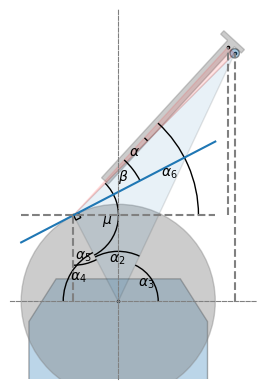

In [63]:
points = [axel_center, support_center, tipp, jig_ref]

fig, ax = plt.subplots()
ax.set_aspect('equal')

jig = mpatches.PathPatch(jig_path(tipp, l_p, alpha_6, d_j/2, d_s/2), alpha=0.4, color='grey') 
ax.add_patch(jig)

plt.scatter(*zip(*points), s=10, marker=".", c='black')

T8 = mpatches.PathPatch(simple_closed_path(t8_vertices), alpha=0.3)
ax.add_patch(T8)

support = mpatches.Circle(support_center, radius=d_s/2, alpha=0.4, ec='black')
ax.add_patch(support)

stone = mpatches.Circle(axel_center, radius=d_w/2, alpha=0.4, color='grey')
ax.add_patch(stone)

correction_triangle = mpatches.PathPatch(simple_closed_path([axel_center, support_center, tipp]), alpha=0.1)
ax.add_patch(correction_triangle)

main_triangle = mpatches.PathPatch(simple_closed_path([tipp, support_center, jig_ref]), color='red', alpha=0.1)
ax.add_patch(main_triangle)

plt.plot(*zip(tangent_1, tangent_2))
ax.add_patch(Rectangle(tipp, 7, 7, fill=False, angle=math.degrees(-alpha_4)))

AngleAnnotation(tipp, tangent_2, jig_ref, ax=ax, size=150, text=r"$\beta$")
AngleAnnotation(tipp, support_center, jig_ref, ax=ax, size=210, text=r"$\alpha$")
AngleAnnotation(tipp, axel_center, support_center, ax=ax, size=90, text=r"$\mu$")
AngleAnnotation(axel_center, support_center, tipp, ax=ax, size=100, text=r"$\alpha_2$")
AngleAnnotation(
    axel_center,
    (axel_center[0] + r, axel_center[1]),
    support_center,
    ax=ax, size=80, text=r"$\alpha_3$"
)
AngleAnnotation(
    axel_center,
    tipp,
    (axel_center[0] - r, axel_center[1]),
    ax=ax, size=110, text=r"$\alpha_4$"
)
AngleAnnotation(
    tipp,
    (-xo, axel_center[1]),
    axel_center,
    ax=ax, size=100, text=r"$\alpha_5$"
)
AngleAnnotation(
    tipp,
    (tipp[0] + r, tipp[1]),
    jig_ref,
    ax=ax, size=250, text=r"$\alpha_6$"
)

plt.plot([axel_center[0] - r, axel_center[1] + r], [tipp[1], tipp[1]], c='grey', linestyle='--')
plt.plot([tipp[0], tipp[0]], [axel_center[1], axel_center[1] + tipp[1]], c='grey', linestyle='--')
plt.plot([support_center[0], support_center[0]],
         [axel_center[1], axel_center[1] + sx], c='grey', linestyle='--')
plt.plot([jig_ref[0], jig_ref[0]],
         [tipp[1], axel_center[1] + jx], c='grey', linestyle='--')


for spine_pos in ['left', 'bottom']:
    ax.spines[spine_pos].set_position('zero')
    ax.spines[spine_pos].set_linestyle('--')
    ax.spines[spine_pos].set_color('gray')

ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks([])
ax.xaxis.set_ticks([])

ax.set_ylim(bottom=-100)
#ax.set_xlim(left=-75)
# ax.set_xlim(right=52)

In [53]:
import ipywidgets